In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# load data

import pymc
db = pymc.database.hdf5.load('300_adaptive_3gbmodel.h5')
is_param = lambda s:'_radius' in s or '_scalingFactor' in s

# inputs
params = []
for s in db._traces:
    if is_param(s):
        params.append(db._traces[s]())
params = np.array(params).T

# outputs
targets = db.dg_gbsa()
print(params.shape,targets.shape)

# experimental data
dg_exp = db.dg_exp

# -2 * log_likelihood
log_likelihood = -0.5 * db.deviance()

((770, 24), (770, 235))


In [4]:
log_likelihood.shape

(770,)

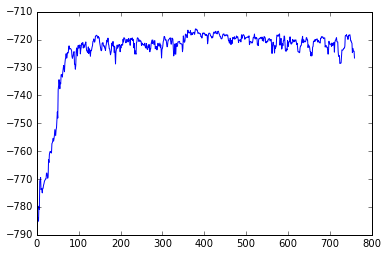

In [5]:
plt.plot(log_likelihood[10:])

How correlated are our samples? Can we use a small subset of these molecules for testing?


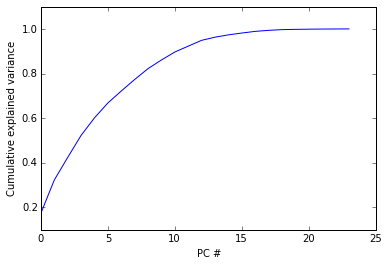

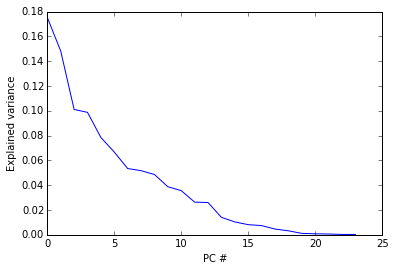

In [6]:
# how much linear structure is there in the inputs?

from sklearn.decomposition import PCA
pca = PCA()
pca.fit(params)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('PC #')
plt.ylabel('Cumulative explained variance')
plt.figure()
plt.plot(pca.explained_variance_ratio_)
plt.xlabel('PC #')
plt.ylabel('Explained variance')
print('How correlated are our samples? Can we use a small subset of these molecules for testing?')

How correlated are our outputs?


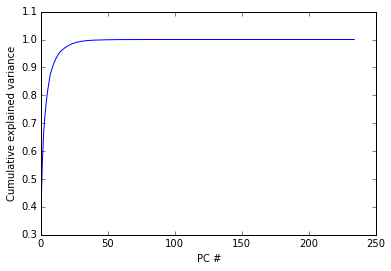

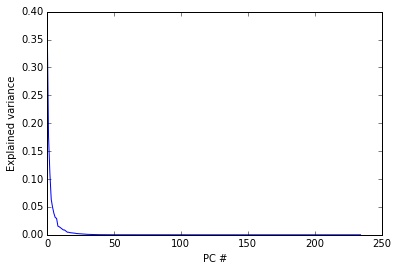

In [7]:
# how much linear structure is there among our ouputs?

pca = PCA()
pca.fit(targets)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('PC #')
plt.ylabel('Cumulative explained variance')
plt.figure()
plt.plot(pca.explained_variance_ratio_)
plt.xlabel('PC #')
plt.ylabel('Explained variance')
print('How correlated are our outputs?')

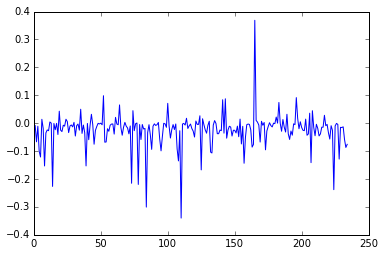

In [130]:
# let's maybe try to select a subset of the 235 compounds that best summarizes the behavior of the rest
# perhaps we can do this by inspecting the leading PCs?
plt.plot(pca.components_[0])

In [124]:
# hmm, let's instead use sparse PCA so that we can better interpret the components
from sklearn.decomposition import SparsePCA
spca = SparsePCA(alpha=0.9)
spca.fit(targets)

SparsePCA(U_init=None, V_init=None, alpha=0.9, max_iter=1000, method='lars',
     n_components=None, n_jobs=1, random_state=None, ridge_alpha=0.01,
     tol=1e-08, verbose=False)

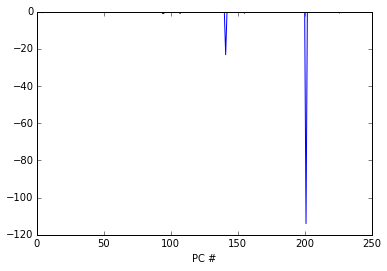

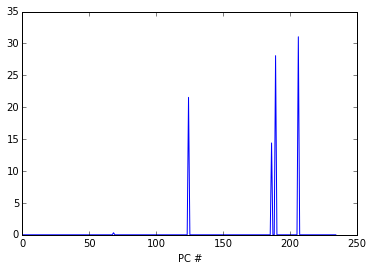

In [136]:
plt.plot(spca.components_[0]);
plt.xlabel('PC #')
plt.figure()
plt.plot(spca.components_[1]);
plt.xlabel('PC #')

In [29]:
# if we fit a PLS model between the inputs and outputs, how well do we do?
from sklearn.cross_decomposition import PLSRegression
pls = PLSRegression()
pls.fit(params,targets)
pls.score(params,targets)

0.48881015562424535

In [8]:
# what if we fit an unregulized linear model between our inputs and outputs?
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(params,targets)
lr.score(params,targets)

0.8550597958818138

In [9]:
# renaming
X = params
y = targets

In [10]:
# let's do this again except with K-fold CV
K = 10

from sklearn.cross_validation import KFold
kfold = KFold(len(params),K,shuffle=True,random_state=0)

train_scores = []
test_scores = []
mse_test = []

for train_index, test_index in kfold:
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    lr = LinearRegression()
    lr.fit(X_train,y_train)
    train_scores.append(lr.score(X_train,y_train))
    test_scores.append(lr.score(X_test,y_test))
    mse_test.append(np.sum((lr.predict(X_test)-y_test)**2) / len(y_test))

In [11]:
print('Train scores: {0:.3f} +/- {1:.3f}'.format(np.mean(train_scores),np.std(train_scores)))
print('Test scores: {0:.3f} +/- {1:.3f}'.format(np.mean(test_scores),np.std(test_scores)))
print('Test MSE: {0:.3f} +/- {1:.3f}'.format(np.mean(mse_test),np.std(mse_test)))

Train scores: 0.856 +/- 0.002
Test scores: 0.836 +/- 0.025
Test MSE: 97.162 +/- 7.768


In [10]:
# hmm, that works surprisingly well-- maybe an even easier thing to do here
# would be to do bayesian linear regression and apply a 

In [104]:
# now let's see how much better we can do if we instead use a GP to interpolate
from sklearn.gaussian_process import GaussianProcess
gp = GaussianProcess()
gp.fit(X,y)

# ugggg what does this error even mean

Exception: Multiple input features cannot have the same target value.

In [12]:
# using the Sheffield library
import GPy

In [8]:
# omg look at all these cool models to try
coolmodels = [GPy.models.GPKroneckerGaussianRegression,
              GPy.models.GPHeteroscedasticRegression,
              GPy.models.SparseGPRegression,
              GPy.models.SparseGPRegressionUncertainInput]

In [9]:
# but first thing's first
gp = GPy.models.GPRegression(X_train,y_train)
gp.optimize()

In [10]:
gp.predict(X_test)[0].shape,y_test.shape

((77, 235), (77, 235))

In [11]:
mse_test = []

for train_index, test_index in kfold:
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    gp = GPy.models.GPRegression(X_train,y_train)
    gp.optimize()
    mse_test.append(np.sum((gp.predict(X_test)[0]-y_test)**2) / len(y_test))

print('Test MSE: {0:.3f} +/- {1:.3f}'.format(np.mean(mse_test),np.std(mse_test)))

Test MSE: 29.545 +/- 2.850


In [ ]:
# okay so this works about ~3x better for unseen data than linear regression does... wooorth iiit?

In [ ]:
# let's pick a better output metric, maybe just one difficult-to-predict target?

In [13]:
import GPyOpt

In [14]:
# for the sake of visualization, let's first look at the projection
# of X that's maximally informative about Molecule 1

y_ = y[:,0]

lr = LinearRegression()
lr.fit(X,y_)

x_ = X.dot(lr.coef_).reshape((len(y),1))
y_ = y[:,0].reshape((len(y),1))

In [15]:
plt.rc('font', family='serif')

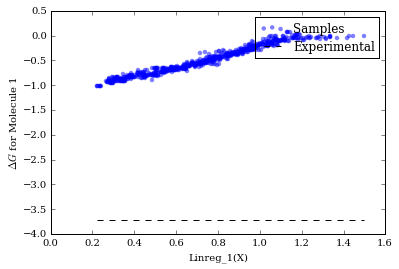

In [96]:
plt.scatter(x_,y_,linewidths=0,alpha=0.5,label='Samples')

plt.hlines(dg_exp[0],min(x_),max(x_),linestyles='--',
           label='Experimental')
plt.legend(loc='best')
plt.xlabel('Linreg_1(X)')
plt.ylabel(r'$\Delta G$ for Molecule 1')
plt.legend(loc='best')

In [16]:
gp = GPy.models.GPRegression(x_,y_)
gp.optimize()

pred_fun = lambda x:gp.predict(x)[0]

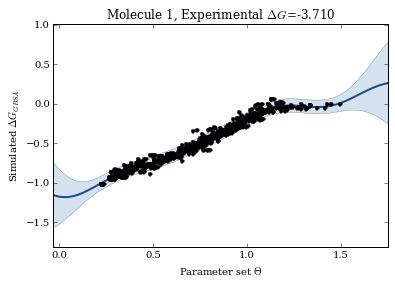

In [17]:
gp.plot(data_symbol='k.')
i = 0
plt.title(r'Molecule {0}, Experimental $\Delta G$={1:.3f}'.format(i+1,dg_exp[i]))
plt.xlabel(r'Parameter set $\Theta$')
plt.ylabel(r'Simulated $\Delta G_{GBSA}$')
#plt.hlines(dg_exp[0],min(x_),max(x_))
#plt.ylim(dg_exp[0]-1.0,1)

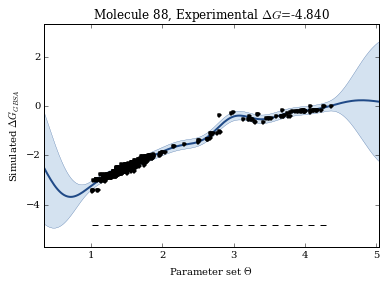

In [25]:
i=87
y_ = y[:,i]

lr = LinearRegression()
lr.fit(X,y_)

x_ = X.dot(lr.coef_).reshape((len(y_),1))
y_ = y_.reshape((len(y_),1))

plt.figure()
gp = GPy.models.GPRegression(x_,y_)
gp.optimize()
gp.plot(data_symbol='k.')
plt.hlines(dg_exp[i],min(x_),max(x_),linestyles='--')
plt.title(r'Molecule {0}, Experimental $\Delta G$={1:.3f}'.format(i+1,dg_exp[i]))
plt.xlabel(r'Parameter set $\Theta$')
plt.ylabel(r'Simulated $\Delta G_{GBSA}$')

In [71]:
# let's generate these plots for each of the molecules in our dataset

In [125]:
for i in range(y.shape[1]):
    y_ = y[:,i]

    lr = LinearRegression()
    lr.fit(X,y_)

    x_ = X.dot(lr.coef_).reshape((len(y_),1))
    y_ = y_.reshape((len(y_),1))

    plt.figure()
    gp = GPy.models.GPRegression(x_,y_)
    gp.optimize()
    gp.plot(data_symbol='k.')
    plt.hlines(dg_exp[i],min(x_),max(x_),linestyles='--')
    plt.title(r'Molecule {0}, Experimental $\Delta G$={1:.3f}'.format(i+1,dg_exp[i]))
    plt.xlabel(r'Parameter set $\Theta$')
    plt.ylabel(r'Simulated $\Delta G_{GBSA}$')
    plt.savefig('gp_plots/molecule_{0}.jpg'.format(i),dpi=300)

    plt.close()

What is the function we want to optimize?

Practically, we want to find a single parameter set to use in simulations, the maximum a posteriori estimate $\text{argmax}_\theta p(\theta | \mathcal{D})$.

For uncertainty quantification, we also want to characterize the full posterior distribution $p(\theta | \mathcal{D})$.

In [23]:
# for many of the above examples, the experimentally observed delta_G is outside the range
# of simulated delta_Gs



# how many? is the relation between parameters and 
converged = (y.max(0)>=dg_exp)*(y.min(0)<=dg_exp)

converged_scores = []
unconverged_scores = []

for i in range(len(converged)):
    y_ = y[:,i]

    lr = LinearRegression()
    lr.fit(X,y_)
    
    score = lr.score(X,y_)
    
    if converged[i]:
        converged_scores.append(score)
    else:
        unconverged_scores.append(score)

print('Linreg R^2 scores for "converged" molecules: {0:.3f} +/- {1:.3f}'.format(np.mean(converged_scores),np.std(converged_scores)))
print('Linreg R^2 scores for "unconverged" molecules: {0:.3f} +/- {1:.3f}'.format(np.mean(unconverged_scores),np.std(unconverged_scores)))

Linreg R^2 scores for "converged" molecules: 0.773 +/- 0.214
Linreg R^2 scores for "unconverged" molecules: 0.842 +/- 0.138


In [26]:
gp = GPy.models.GPRegression(x_,y_)
gp.optimize()

pred_fun = lambda x:gp.predict(x)[0]

bounds = (min(x_)-1.0,max(x_)+1.0)

# let's maybe render where the GP would suggest to 
myBopt = GPyOpt.methods.BayesianOptimization(f=pred_fun,            # function to optimize       
                                             bounds=bounds,        # box-constrains of the problem
                                             acquisition='EI',     # Selects the Expected improvement
                                             acquisition_par = 0)

IndexError: index 1 is out of bounds for axis 0 with size 1